We'll make a video of the "sqrt Johnson-Mehl process": points arriving and discs expanding.

Just like with the Pareto video, we need to colour cells by the "all-time adjacency" graph.

In [10]:
import numpy as np
from scipy.spatial import KDTree
from tqdm import tqdm, trange
import networkx
import colorspace
from PIL import Image, ImageColor, ImageDraw
import sys
from numba import jit

from unconstrained import sample_points
from draw_jm import get_adjacency, colour_graph

In [11]:
def get_arrival_times( rho, max_time=1.0, R=0 ):
    # PROBLEM (major-ish):
    # The "start again if there are more than Nmax arrivals" method
    # means our arrival times don't exactly have the distribution of homogeneous
    # Poisson arrivals. Instead I suppose I should generate some new samples.
    rate = rho*(1+2*R)**2
    Nmax = int(max_time*rate + 2*np.sqrt(max_time*rate)) # Two standard deviations above the mean
    interarrival_times = np.random.exponential(scale=1/rate,size=Nmax)
    arrival_times = np.cumsum(interarrival_times)
    too_late = np.searchsorted(arrival_times,max_time,side='right') # First index where the arrival time is at least max_time
    while too_late == Nmax: # This will be the case if we are unlucky and Nmax points arrived before time max_time. We'll just generate more points.
        interarrival_times = np.append(interarrival_times, np.random.exponential(scale=1/rate,size=Nmax))
        arrival_times = np.cumsum(interarrival_times)
        too_late = np.searchsorted(arrival_times,max_time,side='right') # First index where the arrival time is at least max_time
    return arrival_times[:too_late].copy()

@jit(nopython=True)
def prune_arrivals( times, locations ):
    """
    Given a list of arrival times and locations,
    returns the list of indices which are not covered by earlier points,
    i.e. those which arrived in empty space.
    
    A little slow, but saves a lot of time later.
    """
    N = len(times)
    indices = [0]
    for i in range(1,N):
        covered = False
        x = locations[i]
        t = times[i]
        for j in indices:
            vec = locations[j] - x
            radius2 = t - times[j]
            d2 = np.dot(vec,vec)
            if d2 < radius2:
                covered=True
                break
        if not covered:
            indices.append(i)
    return indices

def get_ball_pixels(centre, radius, img_size):
    """
    Returns the indices of the pixels in the picture
    corresponding to a ball centred at a point in [0,1]^2
    of a given radius.
    Also saves the corresponding (squared) distances.
    
    I suspect a numpy-ish method would be faster:
    create a 2d array containing the (squared) distance between each point in [min_i,max_i]x[min_j,max_j]
    and v, then turn that into an array of bools which we can return along with the distances.
    We might need to also then return (min_i, min_j) so the bool array can be aligned within the image.    
    """
    if radius <= 0:
        return [], []
    v = (img_size-1)*centre
    x,y = v[0], v[1]
    r = (img_size-1)*radius
    r2 = r*r
    min_i = max( 0, int(x-r) )
    max_i = min( img_size-1, int(x+r)+1 )
    min_j = max( 0, int(y-r) )
    max_j = min( img_size-1, int(y+r)+1 )
    in_ball = []
    sq_distances = []
    for i in range(min_i, max_i+1):
        dx2 = (x-i)*(x-i)
        if dx2 > r2:
            continue
        w = np.sqrt( r2 - dx2 )
        for j in range(max(int(y-w),min_j), min(int(y+w)+2,max_j+1)):
            d2 = dx2 + (y-j)**2
            if d2 <= r2:
                in_ball.append((i,j))
                sq_distances.append(d2) # square distances measured in pixels^2.
    return in_ball, sq_distances

def assign_cells( seeds, times, img_size, T=1.0 ):
    """
    Assigns all the pixels in an img_size x img_size picture
    to their respective Johnson-Mehl cells.
    T should be a decent upper bound on the coverage time - smaller T
    means we check fewer points.
    This is a modified version of Moulinec's algorithm,
    in which we assign things which were covered by time T,
    and leave the rest unassigned.
    """
    min_cov_times = np.full((img_size,img_size),np.inf) # running minimum coverage times
    assignments = np.full((img_size,img_size),-1,dtype=int) # everything uncovered is assigned to a separate class.

    for i in trange(len(times)):
        xi = seeds[i]
        ti = times[i]
        radius = np.sqrt(max(0,T-ti))
        indices, d2s = get_ball_pixels(xi, radius, img_size)
        for k, ij_pair in enumerate(indices):
            cov_time = d2s[k]/(img_size*img_size) + ti
            if cov_time < min_cov_times[ij_pair]:
                assignments[ij_pair] = i
                min_cov_times[ij_pair] = cov_time
    return assignments, min_cov_times

## Step-by-step:

In [12]:
fileprefix = "frames/jm-"
rho = 10000000
resolution = 1080
nframes = 10000
circlepause = 100 # How many frames to pause for with the circle around the last covered point
circlesize = int(resolution / 15)
circlewidth = int(resolution/80)

# RANDOMSEED = 6
# np.random.seed(RANDOMSEED)

ratios = np.linspace(0,2.0,num=nframes,endpoint=False)

times = get_arrival_times(rho)
seeds = sample_points(len(times))
arrived = prune_arrivals(times, seeds) # pruning may be slow if rho is very large.
print(f'{len(arrived)} out of {len(times)} seeds germinated.')
times = times[arrived]
seeds = seeds[arrived]

stronglaw = ( (2*np.log(rho) + 4*np.log(np.log(rho))) / (np.pi*rho) )**(1/3) # Much too big for the sqrt-JM model.

# print(f'Last arrival at time {times[-1]}.')

2281 out of 9995310 seeds germinated.


In [16]:
max_time = 0.5*stronglaw
print("First, we generate the final tessellation (which might take a moment)...")
I, cov_times = assign_cells(seeds, times, resolution, T = max_time)

First, we generate the final tessellation (which might take a moment)...


100%|███████████████████████████████████████| 2281/2281 [00:23<00:00, 98.05it/s]


In [17]:
print(f'The final coverage time is {cov_times.max()}, and we ran up to time {max_time}')
# I should use this fact to compute the correct number of frames.

The final coverage time is 0.001108141746877294, and we ran up to time 0.005566766281727011


In [ ]:
print("Cells created, now we will colour them.")
supG = get_adjacency(I)
print(supG)
colours = colour_graph(supG)
print(f'We have a {max(colours.values())+1}-colouring of the cells.')

Cells created, now we will colour them.


Now we can start to generate frames.


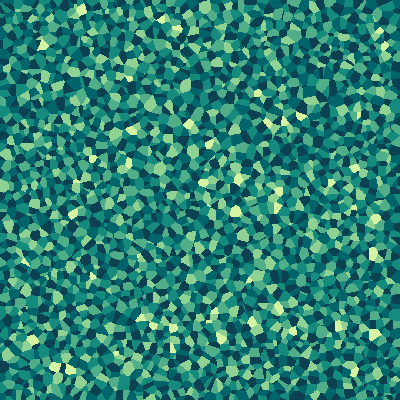

Working on t=0.083500:   4%|▌           | 4174/100000 [03:09<1:17:23, 20.64it/s]

We've found the first covered frame, so we're nearly done!


Done! Go and find your frames in the frames/ folder


In [8]:
print("Now we can start to generate frames.")
c = colorspace.hcl_palettes().get_palette(name="Emrld")
hex_colours = c(max(colours.values())+1)
rgb_colours = [ImageColor.getcolor(col,"RGB") for col in hex_colours]

final_frame = np.full((resolution, resolution, 3), 300, dtype=np.uint8)
for x in range(resolution):
    for y in range(resolution):
        final_frame[x,y,:] = rgb_colours[colours[I[x,y]]]
final_im = Image.fromarray(final_frame)
display(final_im.resize((200,200),Image.NEAREST))
current_frame = np.copy(final_frame)

prev_uncovered = np.full((resolution,resolution),False)

progress = trange(len(ratios),leave=False)
for i in progress:
    t = ratios[i]
    current_time = t*stronglaw
    progress.set_description(f'Working on t={t:.6f}')
    current_frame = np.copy(final_frame)
    uncovered = (cov_times > current_time)
    for channel in range(3):
        current_frame[:,:,channel][uncovered] = 255
    if not (True in uncovered): # This condition is met if all points are covered.
        print("We've found the first covered frame, so we're nearly done!")
        prev_uncovered = cov_times > (ratios[i-1]*stronglaw)
        # image still holds the previous frame
        draw = ImageDraw.Draw(image)
        for x in range(resolution):
            for y in range(resolution):
                if prev_uncovered[x,y]:
                    draw.ellipse((y-circlesize,x-circlesize,y+circlesize,x+circlesize),outline=(255,0,0),width=circlewidth)
        for s in range(circlepause):
            image.save(f'{fileprefix}{ratios[i-1]:.6f}'+'-'+str(s)+'.png')
        for j in range(i,min(len(ratios),i+circlepause)):
            final_im.save(f'{fileprefix}{ratios[j]:.6f}.png') # the remaining frames all look the same.
        break
    else:
        # The frame is uncovered, so draw it and move on.
        image = Image.fromarray(current_frame)
        image.save(f'{fileprefix}{t:.5f}.png')
        prev_uncovered = np.copy(uncovered)

print("Done! Go and find your frames in the frames/ folder")

Then go and stitch your video together with `ffmpeg -framerate 25 -pattern_type glob -i 'frames/jm-*.png' -c:v libx264 JM-VIDEO.mp4`